# Tahap 4: Preprocessing Tanggal, EDA, dan Visualisasi

### Pastikan Anda sudah menginstal library yang dibutuhkan:
### pip install pandas matplotlib wordcloud

In [16]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- 1. Membaca File Hasil Pelabelan ---
input_filepath = '../Data/hasil_pelabelan_transjakarta.csv' 
try:
    df = pd.read_csv(input_filepath)
    print(f"File '{input_filepath}' berhasil dibaca. Jumlah data: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filepath}' tidak ditemukan.")
    exit()

File '../Data/hasil_pelabelan_transjakarta.csv' berhasil dibaca. Jumlah data: 114 baris.


In [17]:
# --- 2. Preprocessing Kolom Tanggal ---
print("\nMemulai preprocessing tanggal...")

# Kamus untuk mengubah nama bulan Bahasa Indonesia ke angka
month_map = {
    'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'mei': '05', 'jun': '06',
    'jul': '07', 'agu': '08', 'sep': '09', 'okt': '10', 'nov': '11', 'des': '12'
}

def convert_date(date_str):
    if not isinstance(date_str, str):
        return None
    
    date_str = date_str.lower().strip()
    
    # Mencocokkan format '16 sep 25' atau '30 Agt 2025'
    match = re.search(r'(\d{1,2})[\s/]+([a-z]{3,})[\s/]*(\d{2,4})?', date_str)
    if match:
        day, month_name, year = match.groups()
        month = month_map.get(month_name[:3], '01')
        if year:
            year = '20' + year if len(year) == 2 else year
        else:
            # Asumsi tahun 2025 jika tidak ada tahun yang disebutkan
            year = '2025' 
        return f"{year}-{month}-{day.zfill(2)}"
        
    # Mencocokkan format '4/29/2025' (M/DD/YYYY) atau '16/9/25' (DD/M/YY)
    # Regex ini lebih fleksibel
    match = re.search(r'(\d{1,2})/(\d{1,2})/(\d{2,4})', date_str)
    if match:
        part1, part2, year = match.groups()
        year = '20' + year if len(year) == 2 else year
        # Asumsi M/D/YYYY jika part1 <= 12, jika tidak D/M/YYYY
        if int(part1) <= 12:
            month, day = part1, part2
        else:
            day, month = part1, part2
        return f"{year}-{month.zfill(2)}-{day.zfill(2)}"

    return None

df['Tanggal_Format'] = df['Tanggal'].apply(convert_date)
df['Tanggal_Format'] = pd.to_datetime(df['Tanggal_Format'], errors='coerce')

# Hapus baris yang tanggalnya tidak bisa diparsing
df.dropna(subset=['Tanggal_Format'], inplace=True)

print("Preprocessing tanggal selesai.")
print(df[['Tanggal', 'Tanggal_Format']].head())


Memulai preprocessing tanggal...
Preprocessing tanggal selesai.
   Tanggal Tanggal_Format
0  16/9/25     2025-09-16
1  29/8/25     2025-08-29
2  12/9/25     2025-12-09
3  19/7/25     2025-07-19
4  24/9/25     2025-09-24



Membuat visualisasi Distribusi Sentimen...


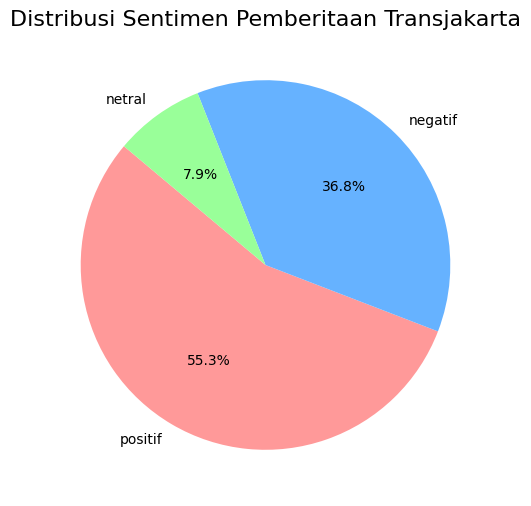

In [18]:
# --- 3. Visualisasi Distribusi Sentimen ---
print("\nMembuat visualisasi Distribusi Sentimen...")
plt.figure(figsize=(8, 6))
sentiment_counts = df['Sentimen'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Distribusi Sentimen Pemberitaan Transjakarta', fontsize=16)
plt.ylabel('')
plt.show()

Membuat visualisasi Word Cloud...


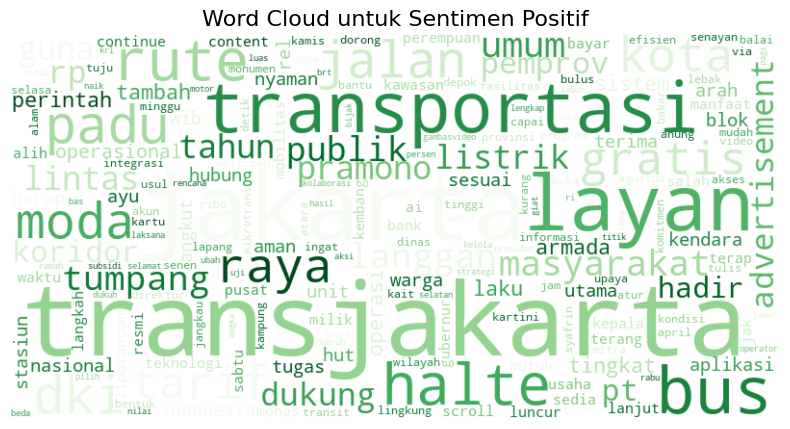

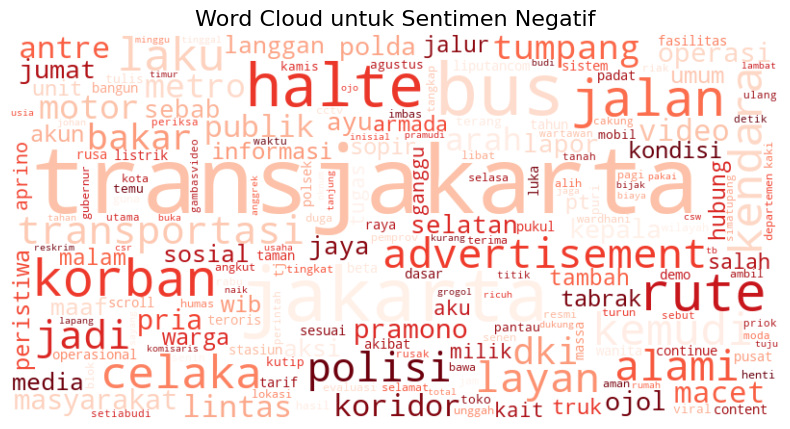

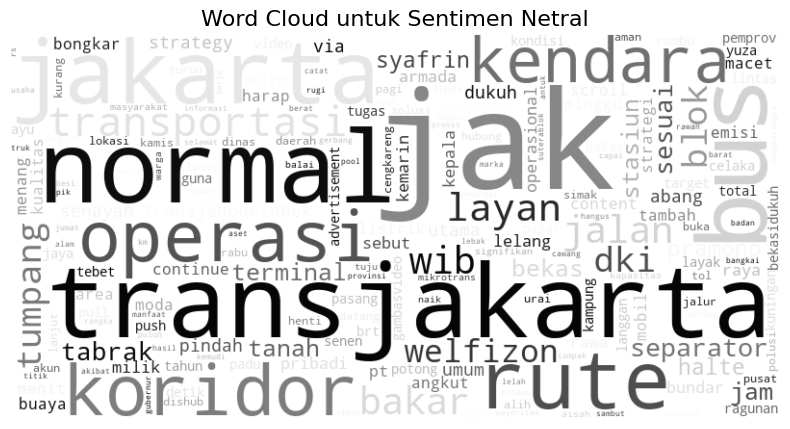

In [19]:
# --- 4. Visualisasi Word Cloud per Sentimen ---
print("Membuat visualisasi Word Cloud...")
sentiments = ['positif', 'negatif', 'netral']
color_maps = {
    'positif': 'Greens',
    'negatif': 'Reds',
    'netral': 'Greys'
}

for sentiment in sentiments:
    text = ' '.join(df[df['Sentimen'] == sentiment]['Teks_Stemmed'].dropna())
    
    if text:
        # Tambahkan parameter colormap di sini
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False, colormap=color_maps[sentiment]).generate(text)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud untuk Sentimen {sentiment.capitalize()}', fontsize=16)
        plt.axis('off')
        plt.show()

Membuat visualisasi Frekuensi Kata...


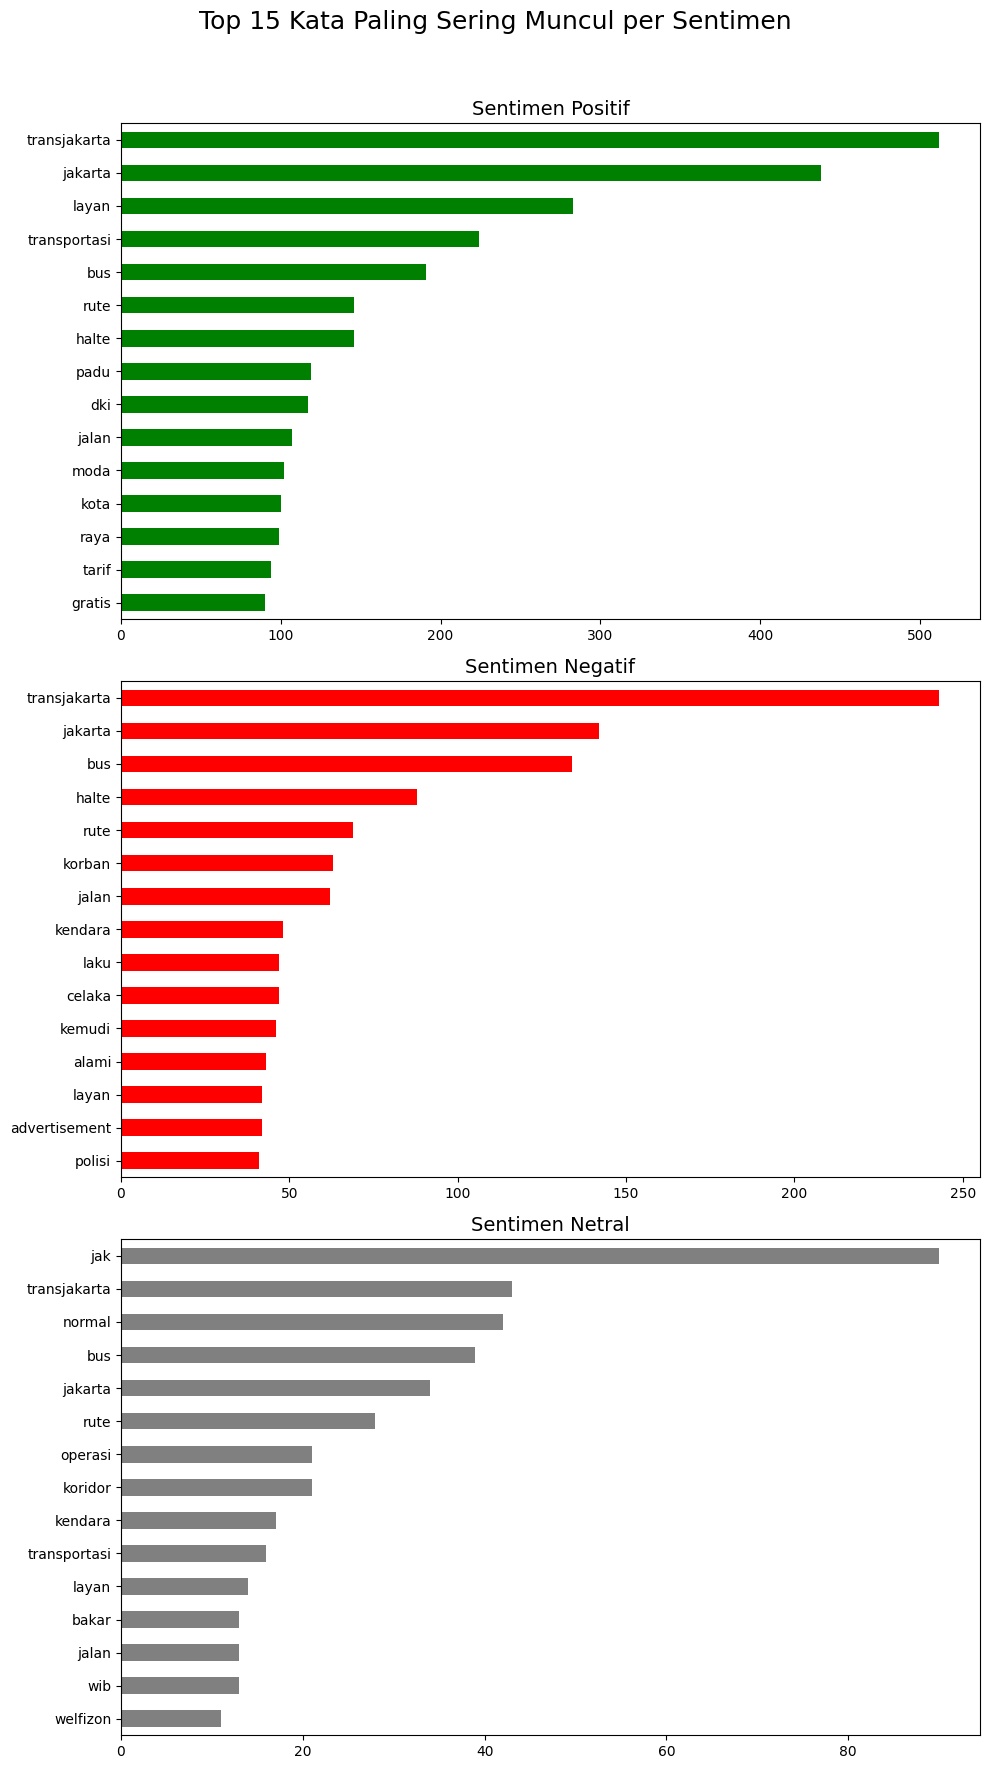

In [20]:
# --- 5. Visualisasi Frekuensi Kata per Sentimen ---
print("Membuat visualisasi Frekuensi Kata...")
fig, axes = plt.subplots(3, 1, figsize=(10, 18))
fig.suptitle('Top 15 Kata Paling Sering Muncul per Sentimen', fontsize=18)

colors = {'positif': 'green', 'negatif': 'red', 'netral': 'grey'}
for i, sentiment in enumerate(sentiments):
    corpus = ' '.join(df[df['Sentimen'] == sentiment]['Teks_Stemmed'].dropna())
    words = corpus.split()
    word_freq = pd.Series(words).value_counts().head(15)
    
    ax = axes[i]
    word_freq.sort_values().plot(kind='barh', ax=ax, color=colors[sentiment])
    ax.set_title(f'Sentimen {sentiment.capitalize()}', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Membuat visualisasi Tren Sentimen per Bulan...


C:\Users\Wede\AppData\Local\Temp\ipykernel_50776\220419490.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time = df_time_analysis.groupby([pd.Grouper(freq='M'), 'Sentimen']).size().unstack(fill_value=0)


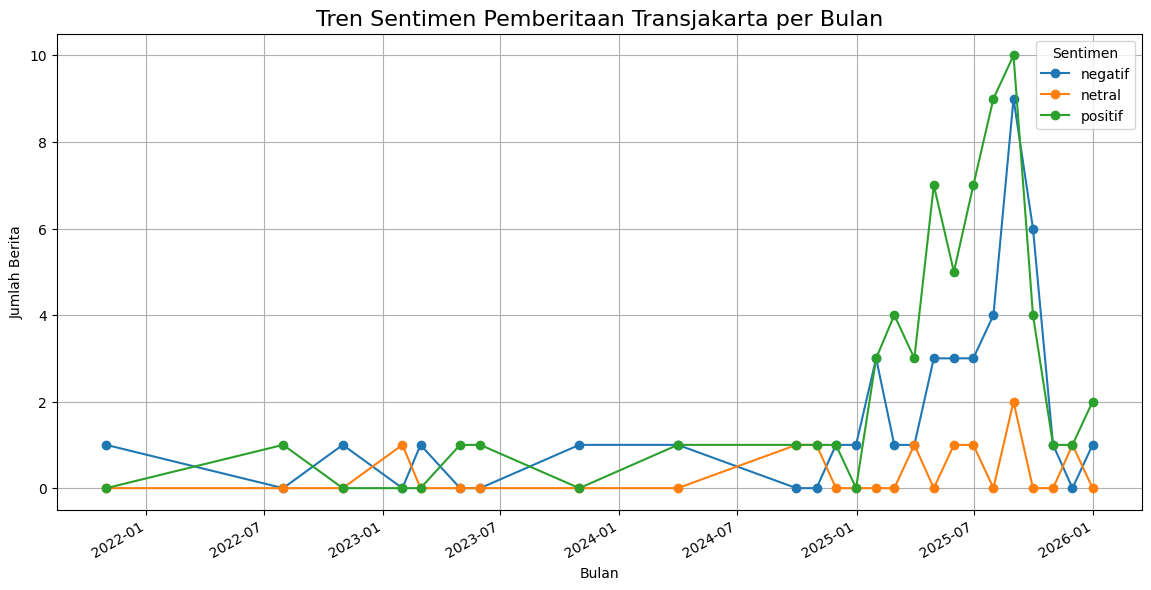

In [21]:
# --- 6. Analisis Sentimen Berdasarkan Waktu ---
print("Membuat visualisasi Tren Sentimen per Bulan...")
# Salin dataframe untuk menghindari SettingWithCopyWarning
df_time_analysis = df.copy()
df_time_analysis.set_index('Tanggal_Format', inplace=True)
# Kelompokkan data per bulan dan hitung jumlah sentimen
sentiment_over_time = df_time_analysis.groupby([pd.Grouper(freq='M'), 'Sentimen']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
sentiment_over_time.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Tren Sentimen Pemberitaan Transjakarta per Bulan', fontsize=16)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Berita')
plt.grid(True)
plt.legend(title='Sentimen')
plt.show()

In [22]:
# Simpan hasil akhir ke file CSV baru
output_filepath = '../Data/hasil_final_analisis_transjakarta.csv'
df.to_csv(output_filepath, index=False, encoding='utf-8')
print(f"\n✅ Proses selesai. Data dengan tanggal terformat disimpan di: {output_filepath}")


✅ Proses selesai. Data dengan tanggal terformat disimpan di: ../Data/hasil_final_analisis_transjakarta.csv
